# Procesamiento de datos  NetCDF
## Yuritzy Pérez Corona 26/09/2023

#### Primer procesamiento de los datos NetCDF del Dopplerscatt en python. Solo para un archivo.
#### Dataset: S-MODE Dopplerscatt

#### Importamos librerías

In [1]:
# Todo lo necesario para el procesamiento
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, matplotlib.colors as colors, matplotlib.dates as mdates
import seaborn as sns
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import signal, fft, integrate

#### Se lee el archivo

In [2]:
data = xr.open_mfdataset('dopplerscatt_20211020_140315.tomoL2CF.nc', parallel=True,).squeeze() #CArga el archivo para usar como data frame
data

E:\ProgramData\anaconda3\Lib\site-packages\xarray\coding\times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
E:\ProgramData\anaconda3\Lib\site-packages\xarray\coding\times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
E:\ProgramData\anaconda3\Lib\site-packages\xarray\coding\times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
E:\ProgramData\anaconda3\Lib\site-packages\xarray\coding\times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


<xarray.Dataset>
Dimensions:                           (x: 958, y: 547, line: 8,
                                       triplet_index: 6, triplet_dim: 3)
Coordinates:
  * x                                 (x) float64 2.385e+05 ... 4.298e+05
  * y                                 (y) float64 4.11e+06 ... 4.22e+06
  * line                              (line) int32 2 3 4 5 6 7 8 9
Dimensions without coordinates: triplet_index, triplet_dim
Data variables: (12/44)
    latitude                          (y, x) float32 dask.array<chunksize=(547, 958), meta=np.ndarray>
    longitude                         (y, x) float32 dask.array<chunksize=(547, 958), meta=np.ndarray>
    triplet                           (triplet_index, triplet_dim) int32 dask.array<chunksize=(6, 3), meta=np.ndarray>
    nobs_all_lines                    (y, x) int32 dask.array<chunksize=(547, 958), meta=np.ndarray>
    mean_observation_time             (line, y, x) datetime64[ns] dask.array<chunksize=(8, 547, 958), meta=np.ndarray>
    mean_triplet_observation_time     (triplet_index, y, x) datetime64[ns] dask.array<chunksize=(6, 547, 958), meta=np.ndarray>
    ...                                ...
    v_current_error_triplet           (triplet_index, y, x) float32 dask.array<chunksize=(6, 547, 958), meta=np.ndarray>
    u_current_all_lines               (y, x) float32 dask.array<chunksize=(547, 958), meta=np.ndarray>
    v_current_all_lines               (y, x) float32 dask.array<chunksize=(547, 958), meta=np.ndarray>
    u_current_error_all_lines         (y, x) float32 dask.array<chunksize=(547, 958), meta=np.ndarray>
    v_current_error_all_lines         (y, x) float32 dask.array<chunksize=(547, 958), meta=np.ndarray>
    spatial_ref                       int32 ...
Attributes: (12/82)
    creator_type:                  group
    creator_name:                  E. Rodriguez, A. Wineteer, T. Gal, D. Perk...
    creator_institution:           NASA/JPL
    creator_email:                 ernesto.rodriguez@jpl.nasa.gov
    creator_url:                   https://scholar.google.com/citations?user=...
    creator_role:                  Researcher
    ...                            ...
    meridional_scale:              0.9999359188810929
    parallel_scale:                0.9999359188220885
    svradial_sigma_max:            0.15
    sin_phi_max:                   0.95
    svradial_max:                  3.0
    geospatial_bounds_crs:         EPSG:32610

#### Como primer paso para el procesamiento de los datos tendremos la observación de las variables, este paso ya se realizó en el notebook anterior; sin embargo, con apoyo de matlab se revisaron mejor las variables y se encontraron varios detalles importantes sobre la distrubución de los datos.
#### El tiempo total del recorrido es de aproximadamente 2 horas con 30 minutos, cada linea se recorre en un tiempo de aproximadamente 20 minutos.
#### De la exploración se encontraron las variables de interés: Latitud, Longitud, Tiempo del recorrido, Velocidad del viento (incluye magnitud y dirección) y Velocidad de las corrientes en sus componentes este (U) y norte (V). Cada una de estas variables está representada como all_lines, triplet, error, merged y line, entenderemos a all_lines como todas las lineas juntas en un mismo tiempo; triplet junta recorridos de tres en tres para convertir las 8 lineas en 6, de forma (2,3,4;3,4,5;....), y line son cada una de las lineas del recorrido por separado, en este caso son 8.  
#### Podemos visualizar cada variable importante con el siguiente código.

#### Observamos primero la ubicación con los valores de latitud y longitud, y revizamos la bandera (esta nos dirá cuales son los datos que debemos recortar puesto que es una matriz llena de 1 y 0, todos los valores = 0 deben ser cortados.

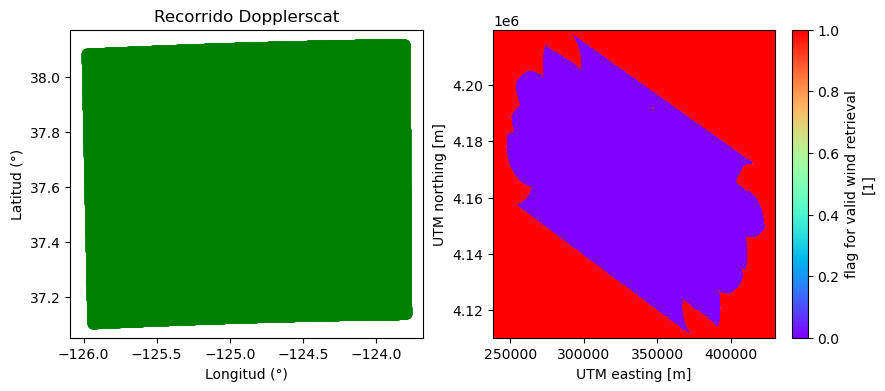

In [3]:
#Grafico del mallado que se tiene, es importante mencionar que esta es una malla regular de 2.5 m por lado, en la cual solamente se tienen datos conforme la variable "azimuth_diversity_flag_all_lines", esta variable también nos dirá los datos que son los correctos por lo que sirve para eliminar los datos erroneos.
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].scatter(data.longitude,data.latitude, color='green') 
axs[0].set_xlabel('Longitud (°)')
axs[0].set_ylabel('Latitud (°)')
axs[0].set_title('Recorrido Dopplerscat')

axs1 = plt.subplot(1, 2, 2)  # Se crea un tercer subplot en la segunda columna
data.azimuth_diversity_flag_all_lines.plot(cmap="rainbow", ax=axs1)


#data.azimuth_diversity_flag_all_lines.plot(cmap="rainbow")

#### Es importante ahora saber en donde se encuentra nuestra región de estudio, por lo que recortamos en el mapa de cartopy nuestra región, donde se muestra la línea de costa, ahora sabemos que estamos en medio del océano frente a las costas de California. Puesto que es una región no costera, sabemos que: las mareas no son tan importantes y la profundidad esta entre 3000-3500 metros (este dato si lo revisé en un mapa con MatLab para precisión).

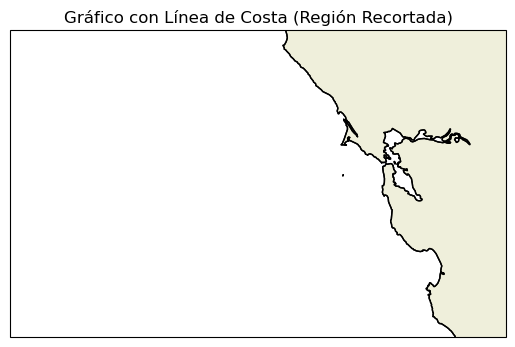

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Definimos los limites de la región de interés de nuestra región
bb = [-127.1000, -121.0000, 36.1000, 39.1000]

# Creamos una figura y ejes con una proyección específica (proyección de Mercator)
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Mercator()})

# Agregamos características del mapa, como líneas de costa y límites políticos
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')

# Agregamos nuestros datos al mapa, en este caso son las corrientes
stream = ax.streamplot(data.longitude, data.latitude, data.u_current_all_lines, data.u_current_all_lines, density=2)

# Personaliza el gráfico según sea necesario
ax.set_title('Gráfico con Línea de Costa (Región Recortada)')

# Define los límites de la proyección para la región de interés
ax.set_extent(bb)

# Mostrar el gráfico
plt.show()

#### Revisemos ahora la velocidad del viento, podemos ver la magnitud y porteriormente un mapa donde se le agrega la dirección del viento, como se muestra, las variaciones de la dirección del viento son muy pequeñas manteniendose en dirección noroeste durante todo el muestreo. Se observa en el histograma que las velocidades están dentro del rango.

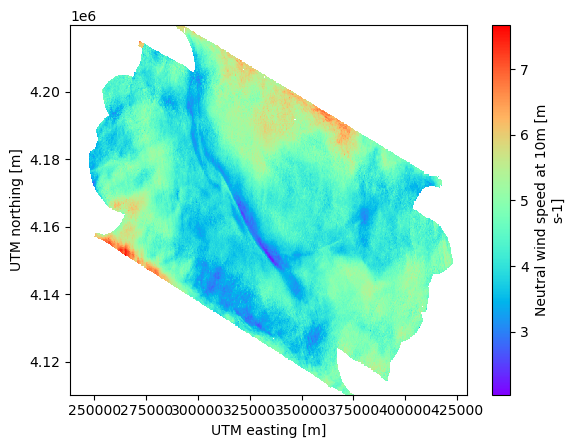

In [5]:
#Gráfico de la velocidad del viento en todas las líneas 
mke=data.wind_speed_all_lines.plot(cmap="rainbow")

#### Grafiquemos ahora la dirección del viento, para ello tomaremos la variable wind_dir_all_lines, para graficarlo nesecitamos saber sus componentes en dirección norte y este, en las características de los datos se tiene que la variable considera 0° al norte y 90° al este lo que nos dice cómo calcular las componentes (Por teorema de pitágoras)

In [6]:
#Calculamos las componentes de la dirección del viento para graficarlo
uwind = np.sin(np.deg2rad(data.wind_dir_all_lines))
vwind = np.cos(np.deg2rad(data.wind_dir_all_lines))

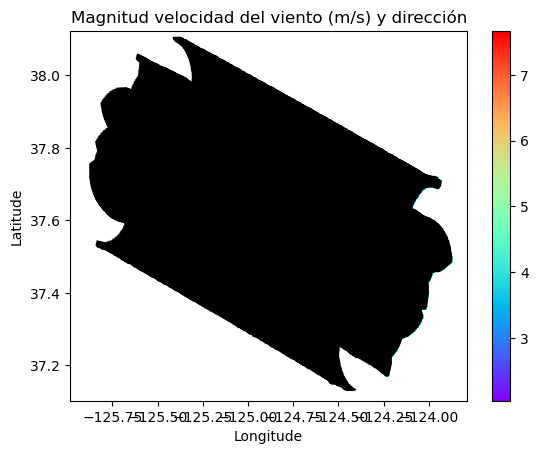

In [7]:
hpc = plt.pcolor(data.longitude, data.latitude, data.wind_speed_all_lines,cmap='rainbow')
plt.title('Magnitud velocidad del viento (m/s) y dirección')
plt.xlabel('Longitude')  
plt.ylabel('Latitude')
plt.colorbar()

plt.quiver(data.longitude, data.latitude, uwind, vwind, scale=100, color='k')

plt.show()

#### En la figura se muestra que todos las flechas del quiver están encimadas, por lo que vamos a seleccionar solamente los valores cada 10 espacios, para aí tener una mejor visualización de la dirección del viento. Considero que esto podría ser una reducción de dimensionalidad, solamente que sin usar las técnicas, haciendolo de manera manual ya que el manejo de los valores faltantes puede tener un impacto significativo en los resultados.

In [8]:
sx, sy = data.latitude.shape 
dz = 10
vsx = np.arange(0, sx, dz) + 1
vsy = np.arange(0, sy, dz) + 1

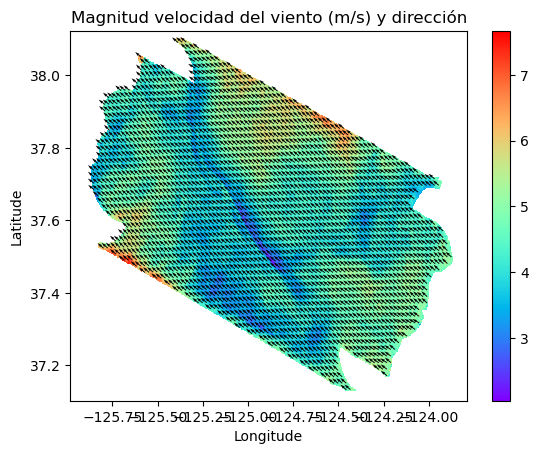

In [9]:
#hpc= data.wind_speed_all_lines.plot(cmap="rainbow")
hpc = plt.pcolor(data.longitude, data.latitude, data.wind_speed_all_lines,cmap='rainbow')
#hpc.set_edgecolor('flat')
#hpc.set_facecolor('flat')
plt.title('Magnitud velocidad del viento (m/s) y dirección')
plt.xlabel('Longitude')  
plt.ylabel('Latitude')
#plt.colormaps('jet')
plt.colorbar()

#vsx = np.arange(0, D['X'].shape[0], dz)
#vsy = np.arange(0, D['Y'].shape[1], dz)

plt.quiver(data.longitude[vsx, vsy], data.latitude[vsx, vsy], uwind[vsx, vsy], vwind[vsx, vsy], scale=50, color='k')

plt.show()

E:\ProgramData\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
E:\ProgramData\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


Text(0.5, 0, 'Magnitud velocidad del viento (m/s)')

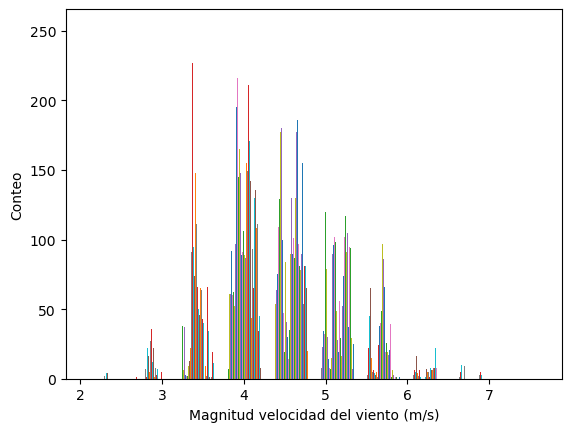

In [10]:
plt.hist(data.wind_speed_all_lines)#, bins=20, color='blue', alpha=0.7) 
plt.ylabel('Conteo')  
plt.xlabel('Magnitud velocidad del viento (m/s)')
# Advertencia sobre los NaN sabemos que los tenemos.

#### La siguiente variable de interés son las corrientes oceánicas, las revisamos primero con un quiver, se muestra que hay zonas en las que las corrientes sobresalen el mapa, por lo que necesitarán ser revisadas. La magnitud, de la magnitud de puede deducir que hay datos fuera de rango en algún punto, por ello será necesario recortar estos datos fuera de rango.

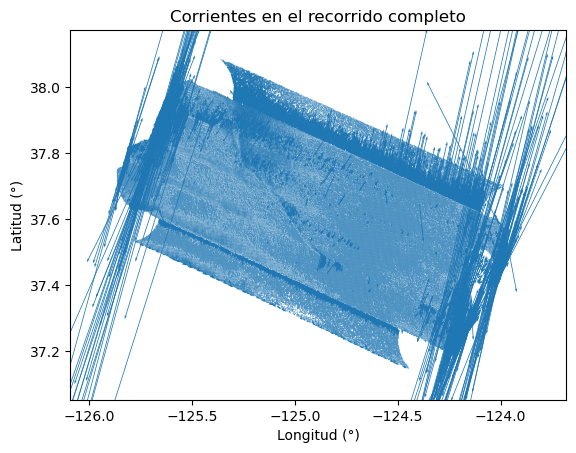

In [11]:
fig, ax = plt.subplots()
ax.quiver(data.longitude,data.latitude, data.u_current_all_lines, data.v_current_all_lines, color="C0", angles='xy', scale_units='xy', scale=300, width=.0015) # Se utilizó quiver porque lo que se quiere representar son los vectores de las corrientes en ambas componentes
plt.xlabel('Longitud (°)')
plt.ylabel('Latitud (°)')
plt.title('Corrientes en el recorrido completo')
plt.show()

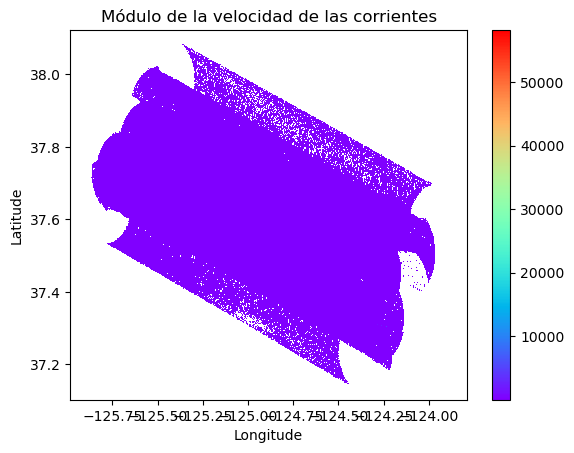

In [12]:
M = np.sqrt(data.u_current_all_lines**2 + data.v_current_all_lines**2)
hpc = plt.pcolormesh(data.longitude, data.latitude, M,cmap='rainbow')
plt.colorbar(hpc)  
plt.xlabel('Longitude')  
plt.ylabel('Latitude')  
plt.title('Módulo de la velocidad de las corrientes')  
#hpc.set_clim(vmin=0, vmax=7) 
plt.show()

#### Como se muestra, las variables tienen inconsistencias al momento de ser graficadas puesto que los valores de la magnitud de las corrientes se muestran en un solo color, eso quiere decir que hay valores que no estan dentro de los rangos comunes, en este caso, los valores fuera de rango se pondran como NaN, puesto que si les ponemos 0 o cualquier otro valor significaran algo y de ser solamente suprimidos pueden afectar en la visualización.
#### Buscamos primero los valores fuera de rango, las corrientes en el océano generalmente son muy pequeñas, una corriente con velocidades altas es la Corriente del Lazo, sin embargo en nuestra zona de estudio, la corriente de California, las velocidades rondan 1 m/s (Huyer, 1983) por lo que estableceremos un máximo de 2 m/s, todos los valores más altos de eso serán sustituidos por NaN y graficamos de nuevo la magnitud de las corrientes.

In [13]:
M = M.where(M <= 2, np.nan)

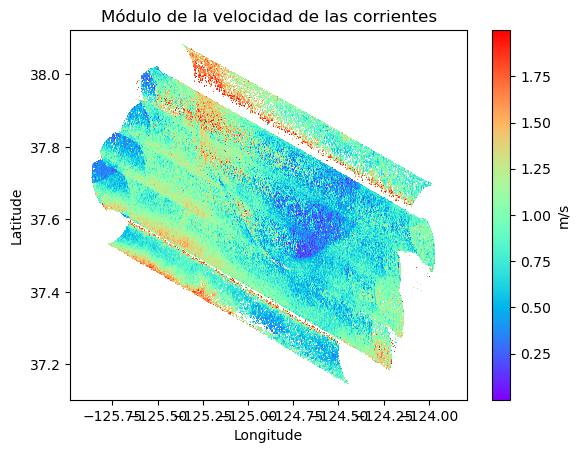

In [14]:
hpc = plt.pcolormesh(data.longitude, data.latitude, M,cmap='rainbow') 
plt.xlabel('Longitude')  
plt.ylabel('Latitude')  
plt.title('Módulo de la velocidad de las corrientes') 
colorbar = fig.colorbar(hpc)
colorbar.set_label('m/s')
#hpc.set_clim(vmin=0, vmax=7) 
plt.show()

#### Una vez que se eliminaron los valores fuera de rango de la magnitud de las corrientes, se puede observar lo que está ocurriendo en la región. Es necesario para esto revisar también las mareas (aunque la influencia sea poca), eso debe ser restado a esta magnitud para así obtener la verdadera magnitud de la corriente. Se puede, de igual manera corregir cada una de las componentes de la velocidad de la corriente de la misma manera, gurdamos las variables corregidas en una nueva y graficamos nuevamente.

In [15]:
#U= data.u_current_all_lines.where(data.u_current_all_lines <= 2, np.nan)
#V= data.v_current_all_lines.where(data.v_current_all_lines <= 2, np.nan)
U = np.where(np.abs(data.u_current_all_lines) > 2, np.nan, data.u_current_all_lines)
V = np.where(np.abs(data.v_current_all_lines) > 2, np.nan, data.v_current_all_lines)

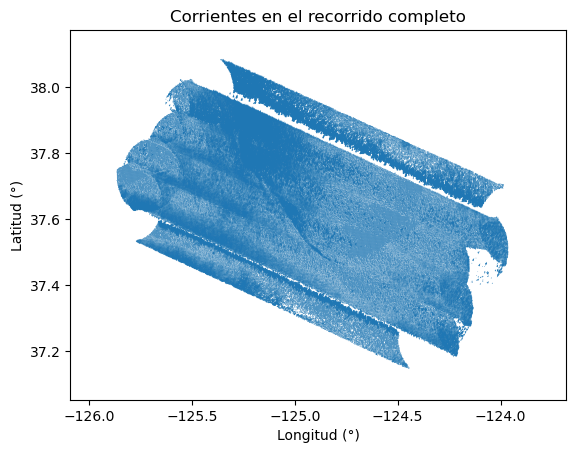

In [16]:
fig, ax = plt.subplots()
ax.quiver(data.longitude,data.latitude, U, V, color="C0", angles='xy', scale_units='xy', scale=200, width=.0015) # Se utilizó quiver porque lo que se quiere representar son los vectores de las corrientes en ambas componentes
plt.xlabel('Longitud (°)')
plt.ylabel('Latitud (°)')
plt.title('Corrientes en el recorrido completo')
plt.show()

#### Ahora se muestran las corrientes corregidas. Con estas nuevas variables podemos ver la dirección de las corrientes por medio de un streamplot, en el se obserba que la corriente se mueve hacia el noreste lo cual puede ser real ya que en general en el océano las corrientes se mueven 90° a la derecha del viento en el hemisferio norte por la fuerza de Coriolis (Gill, 1982).

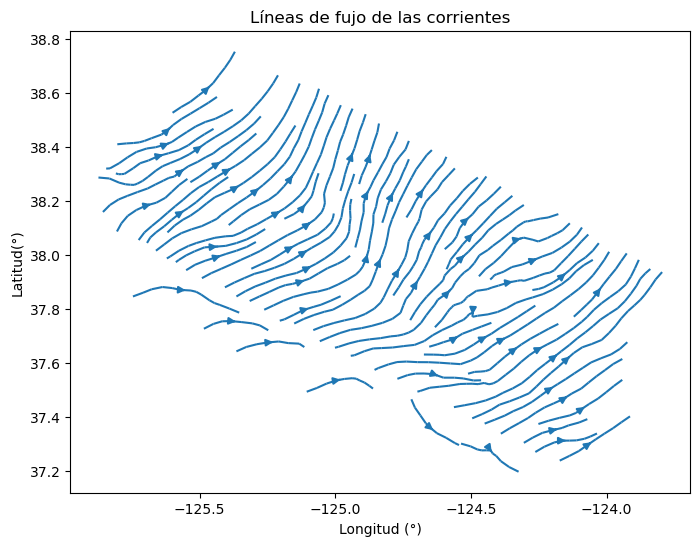

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
x=np.linspace(-126,-123.5,958)
y=np.linspace(37,39,547)
X,Y=np.meshgrid(x,y)
stream=ax.streamplot(X, Y, U, V, density=2) 
ax.set_xlabel('Longitud (°)')
ax.set_ylabel('Latitud(°)')
ax.set_title('Líneas de fujo de las corrientes')
plt.show()

#### Se trató de realizar una reducción dedimensionalidad por medio de algunas técnicas vistas. Se probóaplicar PCA al conjunto de datos completo, eso se realizó primero, pero la computadora no tuvo espacio suficiente y primero se eliminalos las variables que tenian el formato de tiempo, por lo que se trató con variables determinadas; sin embargo, no fue posible debido a la cantidad de NaN que se tienen, cada una de las variables contiene aproximadamente 80% (Calculado por medio de MatALab) de valores NaN que no pueden solamente ser suprimidos para meterlos a PCA o a cualquier otro, se pudieron normalizar los datos por medio de from sklearn.preprocessing import StandardScaler, también tratamos de eliminar las comunas con NaN o las filas lo cual nos deja sin datos y por último probamos imputar los datos con NaN por medio de  from sklearn.impute import SimpleImputer , pero ninguna funcionó. 

#### Se buscó hacer matrices de correlación para buscar la relación entre variables, las únicas relacionables son line y line_merged, la correlación debe ser muy cercana a 1 ya que una viene de la otra. Para esto se omitieron los valores NaN. En la matriz de correlación no se observa debido a la gran cantidad de datos superpuestos, pero tomando en cuenta la barra de colores que solo marca entre 0.9 y 1.1 se puede confirmar.

E:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
E:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
E:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


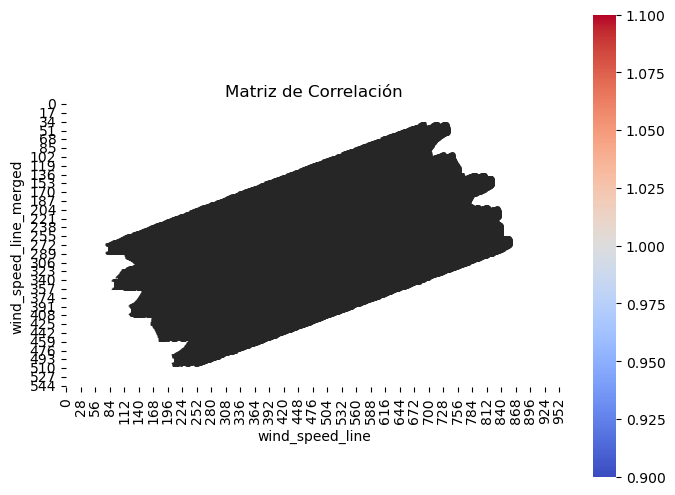

In [18]:
# Selecciona las dos variables de interés
variable1 = data['wind_speed_line']
variable2 = data['wind_speed_line_merged']

# Convierte las variables xarray a numpy arrays
array1 = variable1.values
array2 = variable2.values

# Inicializa una matriz para almacenar las correlaciones
correlations = np.empty(array1.shape[1:]) 

# Calcula las correlaciones omitiendo los valores NaN
for i in range(array1.shape[1]):
    for j in range(array1.shape[2]):
        # Extrae las columnas correspondientes de array1 y array2
        col1 = array1[:, i, j]
        col2 = array2[:, i, j]
        
        # Encuentra los índices donde ambos arrays no tienen NaN
        valid_indices = ~np.isnan(col1) & ~np.isnan(col2)
        
        # Calcula la correlación solo para los valores válidos
        if np.any(valid_indices):
            correlation_matrix = np.corrcoef(col1[valid_indices], col2[valid_indices])
            correlations[i, j] = correlation_matrix[0, 1]
        else:
            correlations[i, j] = np.nan  # Si no hay valores válidos, asigna NaN

# La matriz "correlations" contendrá las correlaciones entre cada par de puntos de datos
print(correlations)

# Crea un mapa de calor (heatmap) de la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", square=True)#, vmin=-1.0, vmax=1.0)


# Configura límites de ejes para acercar la figura
#plt.xlim(0, correlations.shape[1])
#plt.ylim(0, correlations.shape[0])

# Configura etiquetas de los ejes si es necesario
plt.xlabel('wind_speed_line')
plt.ylabel('wind_speed_line_merged')

# Muestra la figura
plt.title('Matriz de Correlación')
plt.show()


#### Revisemos ahora las variables por medio de un graficado de cada una, utilizaremos la velocidad del viento porque considero que es la que se revisa más facilmente.

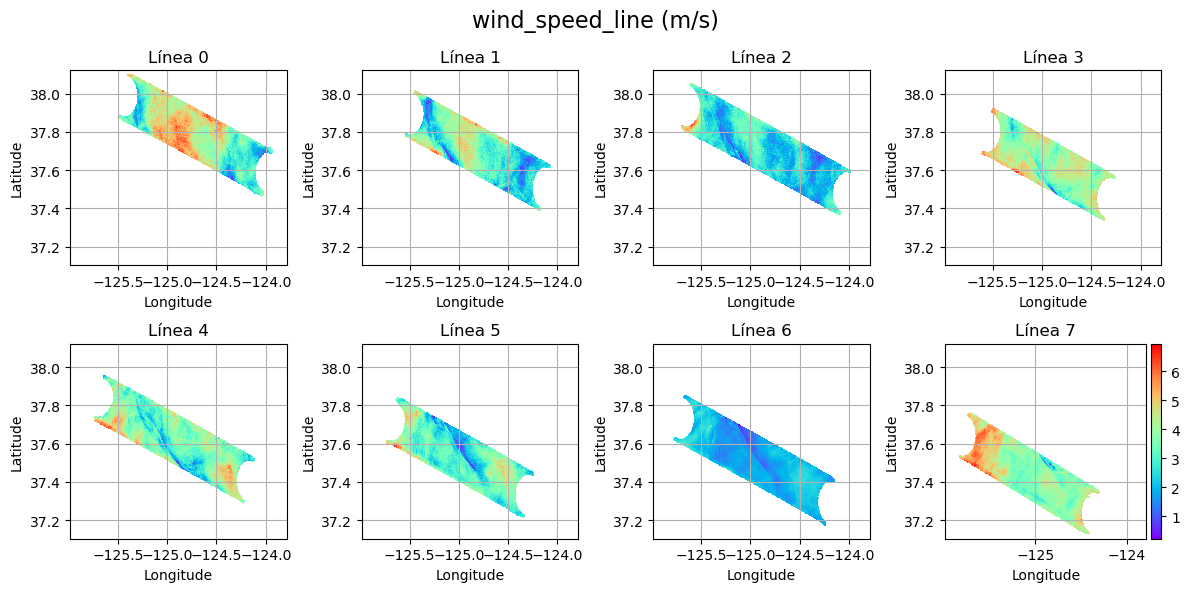

In [19]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Definir los valores mínimos y máximos para el rango de colores
vmin = 0  # Valor mínimo deseado
vmax = 7  # Valor máximo deseado

# Definir las dimensiones para las cuales se harán los subplots
dimensiones = [0, 1, 2, 3, 4, 5, 6, 7]

# Configurar la figura y los subplots
fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # 2 filas, 4 columnas para 8 subplots

# Iterar sobre las dimensiones y crear subplots
for dim, ax in zip(dimensiones, axes.flatten()):
    # Obtener los datos para la dimensión actual
    windline = data.wind_speed_line[dim, :, :]
    
    # Crear el gráfico de pcolor
    hpc = ax.pcolor(data.longitude, data.latitude, windline, cmap='rainbow')
    
    # Configurar etiquetas y título
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Línea {dim}')
    
    # Añadir una cuadrícula a los subplots
    ax.grid(True)
    
# Añadir un colorbar común para todos los subplots
divider = make_axes_locatable(axes[-1, -1])  # Tomamos el último subplot como referencia
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(hpc, cax=cax)#, ticks=[vmin, vmax]) 
#cbar.set_label('Velocidad del viento (m/s)')

# Agregar un título en grande para todas las subfiguras
fig.suptitle('wind_speed_line (m/s)', fontsize=16)
    
# Ajustar los subplots para evitar solapamiento de etiquetas
plt.tight_layout()

# Mostrar la figura
plt.show()

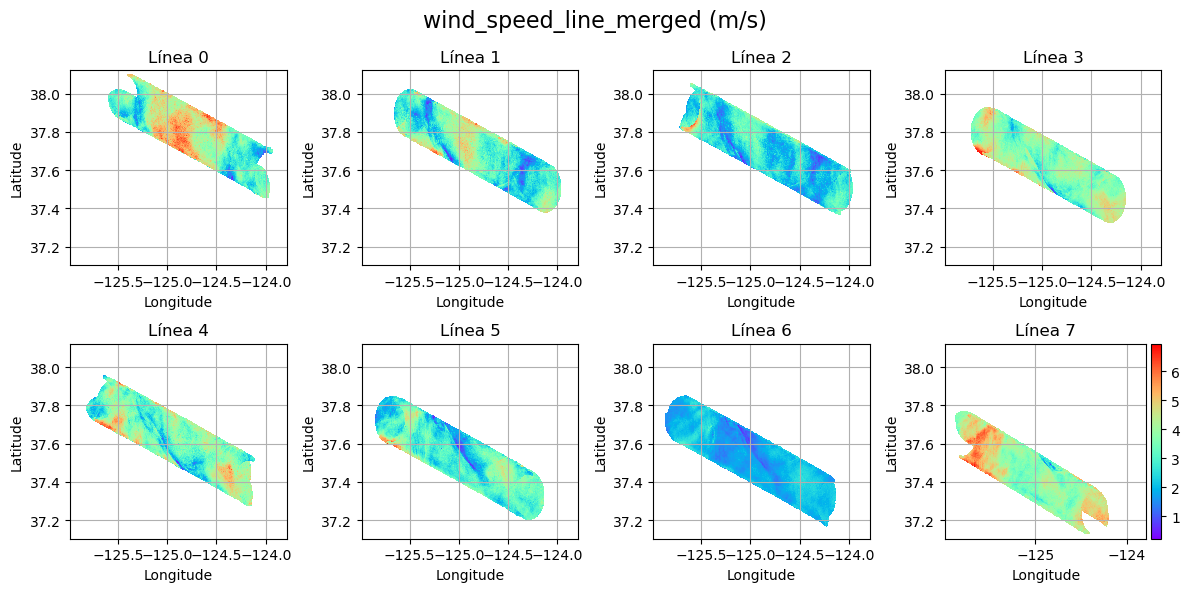

In [20]:
#Combinación Triplet y Line
# Definir las dimensiones para las cuales se harán los subplots
dimensiones = [0, 1, 2, 3, 4, 5, 6, 7]

# Configurar la figura y los subplots
fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # 2 filas, 4 columnas para 8 subplots

# Iterar sobre las dimensiones y crear subplots
for dim, ax in zip(dimensiones, axes.flatten()):
    # Obtener los datos para la dimensión actual
    windmerged = data.wind_speed_line_merged[dim, :, :]
    
    # Crear el gráfico de pcolor
    hpc = ax.pcolor(data.longitude, data.latitude, windmerged, cmap='rainbow')
    
    # Configurar etiquetas y título
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Línea {dim}')
    
    # Añadir una cuadrícula a los subplots
    ax.grid(True)
    
# Añadir un colorbar común para todos los subplots
divider = make_axes_locatable(axes[-1, -1])  # Tomamos el último subplot como referencia
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(hpc, cax=cax)#, ticks=[vmin, vmax]) 
#cbar.set_label('Velocidad del viento (m/s)')

# Agregar un título en grande para todas las subfiguras
fig.suptitle('wind_speed_line_merged (m/s)', fontsize=16)
    
# Ajustar los subplots para evitar solapamiento de etiquetas
plt.tight_layout()

# Mostrar la figura
plt.show()

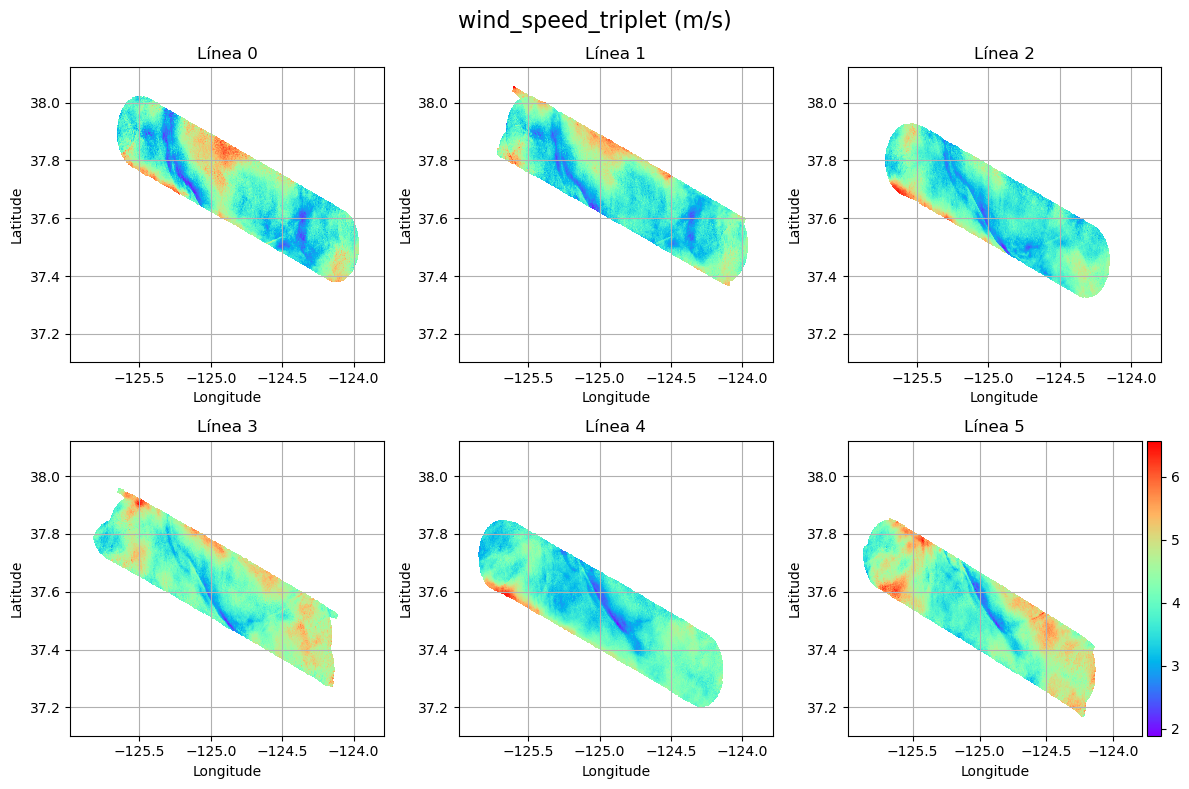

In [21]:
# Definir las dimensiones para las cuales quieres hacer subplots
dimensiones = [0, 1, 2, 3, 4, 5]

# Configurar la figura y los subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 2 filas, 3 columnas para 6 subplots

# Iterar sobre las dimensiones y crear subplots
for dim, ax in zip(dimensiones, axes.flatten()):
    # Obtener los datos para la dimensión actual
    windtriplet = data.wind_speed_triplet[dim, :, :]
    
    # Crear el gráfico de pcolor
    hpc = ax.pcolor(data.longitude, data.latitude, windtriplet, cmap='rainbow')
    
    # Configurar etiquetas y título
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Línea {dim}')
    
    # Añadir una cuadrícula a los subplots
    ax.grid(True)

# Añadir un colorbar común para todos los subplots
divider = make_axes_locatable(axes[-1, -1])  # Tomamos el último subplot como referencia
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(hpc, cax=cax)#, ticks=[vmin, vmax]) 
#cbar.set_label('Velocidad del viento (m/s)')

# Agregar un título en grande para todas las subfiguras
fig.suptitle('wind_speed_triplet (m/s)', fontsize=16)

# Ajustar los subplots para evitar solapamiento de etiquetas
plt.tight_layout()

# Mostrar la figura
plt.show()

#### Se puede ver que las tres variables son prácticamente lo mismo, el uso de cada una dependerá de lo que se busque obtener. En cada analisis no se deben usar todas, bastará con elegir la más adecuaada dependiendo el tipo de cálculo.

### Conclusiones
#### Se expandió la exploración incial de los datos para observarlas variables y se utilizó MATLAB para obtener información más detallada debido a que es un programa donde ya se tiene más experiencia. Se identificaron las variables de interés con claridad que incluyen latitud, longitud, tiempo del recorrido, velocidad del viento (magnitud y dirección) y velocidad de las corrientes en sus componentes este (U) y norte (V). 
#### Para el procesamiento de los datos se abordó la corrección de valores fuera de rango y la manipulación de valores NaN en los datos, lo que es crucial para garantizar la calidad de tus resultados.
#### Se intentó aplicar reducción de dimensionalidad como PCA para simplificar los datos, pero fue un deafio para la gran cantidad de valores NaN, además de que realizarlo podría eliminar información importante.
####  Se realizó la matriz de correlación solamente para visualizar cómo son iguales las variables.
#### Se realizó un análisis detallado de las variables de velocidad del viento tanto magnitud como dirección. Se identifica que las variables all_lines, line, line_merged y line_triplet son practicamente iguales, por lo que la elección de cuál utilizar dependerá del análisis específico que se desee realizar.
#### Considero que la información obtenida sobre las variables es valiosa y es un paso inicial fundamental para avanzar con análisis más complejos y modelado de datos.

### Referencias
#### Huyer, Adriana. 1983. “Coastal Upwelling in the California Current System”. Progress in Oceanography 12 (3): 259–84. https://doi.org/10.1016/0079-6611(83)90010-1.
#### Gill, A., 1982. Atmosphere-Ocean Dynamics. Academic Press, San Diego.